# Coursework for MRI reconstruction (Autumn 2019)

In this tutorial, we provide the data loader to read and process the MRI data in order to ease the difficulty of training your network. By providing this, we hope you focus more on methodology development. Please feel free to change it to suit what you need.

In [1]:
#ALL IMPORTS
import h5py, os
from functions import transforms as T
from functions.subsample import MaskFunc
from scipy.io import loadmat
from torch.utils.data import DataLoader
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
#cuda
import torch.optim as optim
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' #'cpu'

In [2]:
##### UNET MODEL ######

class ConvBlock(nn.Module):
    """
    A Convolutional Block that consists of two convolution layers each followed by
    instance normalization, relu activation and dropout.
    """

    def __init__(self, in_chans, out_chans, drop_prob):
        """
        Args:
            in_chans (int): Number of channels in the input.
            out_chans (int): Number of channels in the output.
            drop_prob (float): Dropout probability.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.drop_prob = drop_prob

        self.layers = nn.Sequential(
            nn.Conv2d(in_chans, out_chans, kernel_size=3, padding=1),
            nn.InstanceNorm2d(out_chans),
            nn.ReLU(),
            nn.Dropout2d(drop_prob),
            nn.Conv2d(out_chans, out_chans, kernel_size=3, padding=1),
            nn.InstanceNorm2d(out_chans),
            nn.ReLU(),
            nn.Dropout2d(drop_prob)
        )

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]

        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        return self.layers(input)

    def __repr__(self):
        return f'ConvBlock(in_chans={self.in_chans}, out_chans={self.out_chans}, ' \
            f'drop_prob={self.drop_prob})'


class UnetModel(nn.Module):
    """
    PyTorch implementation of a U-Net model.

    This is based on:
        Olaf Ronneberger, Philipp Fischer, and Thomas Brox. U-net: Convolutional networks
        for biomedical image segmentation. In International Conference on Medical image
        computing and computer-assisted intervention, pages 234–241. Springer, 2015.
    """

    def __init__(self, in_chans, out_chans, chans, num_pool_layers, drop_prob):
        """
        Args:
            in_chans (int): Number of channels in the input to the U-Net model.
            out_chans (int): Number of channels in the output to the U-Net model.
            chans (int): Number of output channels of the first convolution layer.
            num_pool_layers (int): Number of down-sampling and up-sampling layers.
            drop_prob (float): Dropout probability.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.chans = chans
        self.num_pool_layers = num_pool_layers
        self.drop_prob = drop_prob

        self.down_sample_layers = nn.ModuleList([ConvBlock(in_chans, chans, drop_prob)])
        ch = chans
        for i in range(num_pool_layers - 1):
            self.down_sample_layers += [ConvBlock(ch, ch * 2, drop_prob)]
            ch *= 2
        self.conv = ConvBlock(ch, ch, drop_prob)

        self.up_sample_layers = nn.ModuleList()
        for i in range(num_pool_layers - 1):
            self.up_sample_layers += [ConvBlock(ch * 2, ch // 2, drop_prob)]
            ch //= 2
        self.up_sample_layers += [ConvBlock(ch * 2, ch, drop_prob)]
        self.conv2 = nn.Sequential(
            nn.Conv2d(ch, ch // 2, kernel_size=1),
            nn.Conv2d(ch // 2, out_chans, kernel_size=1),
            nn.Conv2d(out_chans, out_chans, kernel_size=1),
        )

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]

        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        stack = []
        output = input
        # Apply down-sampling layers
        for layer in self.down_sample_layers:
            output = layer(output)
            stack.append(output)
            output = F.max_pool2d(output, kernel_size=2)

        output = self.conv(output)

        # Apply up-sampling layers
        for layer in self.up_sample_layers:
            output = F.interpolate(output, scale_factor=2, mode='bilinear', align_corners=False)
            output = torch.cat([output, stack.pop()], dim=1)
            output = layer(output)
        return self.conv2(output)

In [3]:
#pre-defined ultily functions used in creating the neural net

def show_slices(data, slice_nums, cmap=None): # visualisation
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')
    plt.show()


def get_epoch_batch(subject_id, acc, center_fract, use_seed=True):
    ''' random select a few slices (batch_size) from each volume'''

    fname, rawdata_name, slice = subject_id  
    
    with h5py.File(rawdata_name, 'r') as data:
        rawdata = data['kspace'][slice]
                      
    slice_kspace = T.to_tensor(rawdata).unsqueeze(0)
    S, Ny, Nx, ps = slice_kspace.shape

    # apply random mask
    shape = np.array(slice_kspace.shape)
    mask_func = MaskFunc(center_fractions=[center_fract], accelerations=[acc])
    seed = None if not use_seed else tuple(map(ord, fname))
    mask = mask_func(shape, seed)
      
    # undersample
    masked_kspace = torch.where(mask == 0, torch.Tensor([0]), slice_kspace)
    masks = mask.repeat(S, Ny, 1, ps)

    img_gt, img_und = T.ifft2(slice_kspace), T.ifft2(masked_kspace)

    # perform data normalization which is important for network to learn useful features
    # during inference there is no ground truth image so use the zero-filled recon to normalize
    norm = T.complex_abs(img_und).max()
    if norm < 1e-6: norm = 1e-6
    
#     A = cropped_img_und.squeeze().detach().cpu()
#     C = cropped_gt.squeeze().squeeze().detach().cpu()
    
    # normalized data
    img_gt, img_und, rawdata_und = img_gt/norm, img_und/norm, masked_kspace/norm
    
    volume_image_abs = T.complex_abs(img_gt) 
    cropped_gt = T.center_crop(volume_image_abs, [320, 320])
    cropped_gt = cropped_gt
        
    volume_image_abs = T.complex_abs(img_und) 
    cropped_img_und = T.center_crop(volume_image_abs, [320, 320])
    cropped_img_und = cropped_img_und
        
    return cropped_gt,cropped_img_und, norm
  #return img_gt.squeeze(0), img_und.squeeze(0), rawdata_und.squeeze(0), masks.squeeze(0), norm

class MRIDataset(DataLoader):
    def __init__(self, data_list, acceleration, center_fraction, use_seed):
        self.data_list = data_list
        self.acceleration = acceleration
        self.center_fraction = center_fraction
        self.use_seed = use_seed

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        subject_id = self.data_list[idx]
        return get_epoch_batch(subject_id, self.acceleration, self.center_fraction, self.use_seed)
    
    def load_data_path(train_data_path, val_data_path):
        """ Go through each subset (training, validation) and list all 
        the file names, the file paths and the slices of subjects in the training and validation sets 
        """

        data_list = {}
        train_and_val = ['train', 'val']
        data_path = [train_data_path, val_data_path]

        for i in range(len(data_path)):

            data_list[train_and_val[i]] = []

            which_data_path = data_path[i]

            for fname in sorted(os.listdir(which_data_path)):

                subject_data_path = os.path.join(which_data_path, fname)

                if not os.path.isfile(subject_data_path): continue 

                with h5py.File(subject_data_path, 'r') as data:
                    num_slice = data['kspace'].shape[0]

                # the first 5 slices are mostly noise so it is better to exlude them
                data_list[train_and_val[i]] += [(fname, subject_data_path, slice) for slice in range(5, num_slice)]

        return data_list  
   
    
from skimage.measure import compare_ssim  
def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return compare_ssim(
        gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max()
    )  


def show_slices(data, slice_nums, cmap=None): # visualisation
    fig = plt.figure(figsize=(15,10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')

In [4]:

# def save_reconstructions(reconstructions, out_dir):
#     """
#     Saves the reconstructions from a model into h5 files that is appropriate for submission
#     to the leaderboard.
#     Args:
#         reconstructions (dict[str, np.array]): A dictionary mapping input filenames to
#             corresponding reconstructions (of shape num_slices x height x width).
#         out_dir (pathlib.Path): Path to the output directory where the reconstructions
#             should be saved.
#     """
#     for fname, recons in reconstructions.items():
#         subject_path = os.path.join(out_dir, fname)
#         print(subject_path)
#         with h5py.File(subject_path, 'w') as f:
#             f.create_dataset('cropped_4af', data=recons['crop_4af'])
#             f.create_dataset('cropped_8af', data=recons['crop_8af'])
#             #f.create_dataset('recon_4af', data=recons)
#             #f.create_dataset('recon_8af', data=recons8af[fname])

# model_4 = torch.load(r'/home/students/jtm812/neural_net_fMRI-master/unet_model_save_120ep_adam_le1_b5_L1_4f.pkl')

# model_8 = torch.load(r'/home/students/jtm812/neural_net_fMRI-master/unet_model_save_120ep_adam_le1_b5_L1_8f.pkl')

# model_4.eval()
# model_8.eval()
# file_path = r'/data/local/NC2019MRI/test'
# reconstructions = {}

# num = 0
# for fname in sorted(os.listdir(file_path)):
#     subject_path = os.path.join(file_path, fname)
#     with h5py.File(subject_path, "r") as hf:
#         # print(f'file {fname} key is {list(hf.keys())}')
#         volume_kspace_4af = hf['kspace_4af'][()]
#         mask_4af = hf['mask_4af'][()]
#         volume_kspace_8af = hf['kspace_8af'][()]
#         mask_8af = hf['mask_8af'][()]
#         # print(volume_kspace_4af.shape)

#         volume_kspace_4 = T.to_tensor((volume_kspace_4af))
#         volume_image_4 = T.ifft2(volume_kspace_4)
#         volume_image_abs_4af = T.complex_abs(volume_image_4)
#         cropped_4af = T.center_crop(volume_image_abs_4af, [320, 320]).to(device)

#         volume_kspace8 = T.to_tensor((volume_kspace_8af))
#         volume_image_8 = T.ifft2(volume_kspace8)
#         volume_image_abs_8af = T.complex_abs(volume_image_8)
#         cropped_8af = T.center_crop(volume_image_abs_8af, [320, 320]).to(device)
#         output_4 = []
#         output_8 = []
#         # print(output.shape)
#         count = 0
#         num += 1
#         for i in range(len(cropped_4af)):
#             # print(cropped_4af[i].unsqueeze(0).unsqueeze(0).shape)
#             output_slice_4 = model_4(cropped_4af[i].unsqueeze(0).unsqueeze(0))
#             output_slice_8 = model_8(cropped_8af[i].unsqueeze(0).unsqueeze(0))
#             # print(output_slice_4.shape)
#             # break
#             output_4.append(output_slice_4.squeeze().detach().cpu().numpy())
#             output_8.append(output_slice_8.squeeze().detach().cpu().numpy())
#             # print(output_slice.squeeze().shape)
#             count += 1
#             print(count)
#         print('This is the %dth sample' % num)
#         reconstructions[fname] = {}
#         reconstructions[fname]['crop_4af'] = np.array(output_4)
#         reconstructions[fname]['crop_8af'] = np.array(output_8)
#         # recon_4[fname] = output_4
#         # recon_8[fname] = output_8



In [11]:

def save_reconstructions(reconstructions, out_dir):
    """
    Saves the reconstructions from a model into h5 files that is appropriate for submission
    to the leaderboard.
    Args:
    
        reconstructions (dict[str, np.array]): A dictionary mapping input filenames to
            corresponding reconstructions (of shape num_slices x height x width).
        out_dir (pathlib.Path): Path to the output directory where the reconstructions
            should be saved.
    """
    for fname, recons in reconstructions.items():
        subject_path = os.path.join(out_dir, fname)
        print(subject_path)
        with h5py.File(subject_path, 'w') as f:
            f.create_dataset('cropped_4af', data=recons['crop_4af'])
            f.create_dataset('cropped_8af', data=recons['crop_8af'])
            # f.create_dataset('recon_4af', data=recons)
            # f.create_dataset('recon_8af', data=recons8af[fname])

model_8 = torch.load(r'/home/students/jtm812/neural_net_fMRI-master/unet_model_save_50ep_sgd_le1_b5_L1.pkl')
model_4 = torch.load(r'/home/students/jtm812/neural_net_fMRI-master/unet_model_save_50ep_sgd_le1_b5_L1.pkl')


model_4.eval()
model_8.eval()
file_path = r'/data/local/NC2019MRI/test'
reconstructions = {}

num = 0
for fname in sorted(os.listdir(file_path)):
    subject_path = os.path.join(file_path, fname)
    with h5py.File(subject_path, "r") as hf:
        # print(f'file {fname} key is {list(hf.keys())}')
        volume_kspace_4af = hf['kspace_4af'][()]
        mask_4af = hf['mask_4af'][()]
        volume_kspace_8af = hf['kspace_8af'][()]
        mask_8af = hf['mask_8af'][()]
        # print(volume_kspace_4af.shape)

        volume_kspace_4 = T.to_tensor((volume_kspace_4af))
        volume_image_4 = T.ifft2(volume_kspace_4)
        volume_image_abs_4af = T.complex_abs(volume_image_4)
        cropped_4af = T.center_crop(volume_image_abs_4af, [320, 320]).to(device)

        volume_kspace8 = T.to_tensor((volume_kspace_8af))
        volume_image_8 = T.ifft2(volume_kspace8)
        volume_image_abs_8af = T.complex_abs(volume_image_8)
        cropped_8af = T.center_crop(volume_image_abs_8af, [320, 320]).to(device)
        output_4 = []
        output_8 = []
        # print(output.shape)
        count = 0
        num += 1
        for i in range(len(cropped_4af)):
            # print(cropped_4af[i].unsqueeze(0).unsqueeze(0).shape)
            output_slice_4 = model_4(cropped_4af[i].unsqueeze(0).unsqueeze(0))
            output_slice_8 = model_8(cropped_8af[i].unsqueeze(0).unsqueeze(0))
            # print(output_slice_4.shape)
            # break
            output_4.append(output_slice_4.squeeze().detach().cpu().numpy())
            output_8.append(output_slice_8.squeeze().detach().cpu().numpy())
            # print(output_slice.squeeze().shape)
            count += 1
            print(count)
        print('This is the %dth sample' % num)
        reconstructions[fname] = {}
        reconstructions[fname]['crop_4af'] = np.array(output_4)
        reconstructions[fname]['crop_8af'] = np.array(output_8)
        # recon_4[fname] = output_4
        # recon_8[fname] = output_8

out_dir ='/run/media/jtm812/0604-55BF/lastchance'  # where you want to save your result.
if not (os.path.exists(out_dir)): os.makedirs(out_dir)
save_reconstructions(reconstructions, out_dir)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
This is the 1th sample
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
This is the 2th sample
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
This is the 3th sample
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
This is the 4th sample
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
This is the 5th sample
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
This is the 6th sample
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
This is the 7th sample
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
This is the 8th sample
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


### 

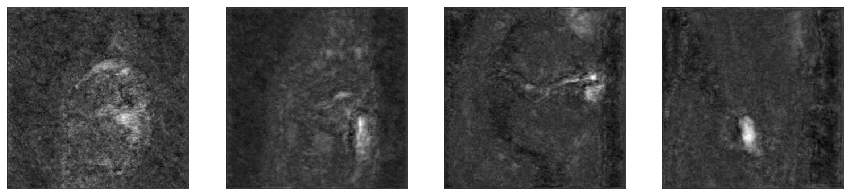

In [13]:

filepath = '/run/media/jtm812/0604-55BF/lastchance/file1001143.h5'

with h5py.File(filepath,"r")as hf:
    cropped_4af=hf['cropped_4af'][()]
    show_slices(cropped_4af,[5,10,20,30],cmap='gray')